<a href="https://colab.research.google.com/github/pooja-joshi-bits/EPFforAll/blob/main/NordPool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Regeneration recheck


Structure (DNN Model- Lago)
4 layers (1 input layer, 2 hidden layers, 1 output layer)
Optimizer used- Adam


Training Dataset (208 weeks) (Four years--training and validation dataset)
Total training dates: 01.01.2013 to 26.12.2016 
training dataset dates: first 166 weeks i.e. 01.01.2013 to 07.03.2016
Validtion dataset dates: last 42 weeks i.e. 08.03.2016 to 26.12.2016
Testing dataset dates (104 weeks): 27.12.2016 to 24.12.2018

Input features:
The available input features to forecast the 24 day-ahead prices of day 𝑑, i.e. 𝐩𝑑 = [𝑝𝑑,1, …, 𝑝𝑑,24]
a) Historical day-ahead prices of the previous three days and one week ago, i.e. 𝐩𝑑−1, 𝐩𝑑−2, 𝐩𝑑−3,𝐩𝑑−7.
b)The day-ahead forecasts of the two variables of interest (day-ahead load forecast and the day-ahead wind generation forecast)for day 𝑑 available on day 𝑑 − 1, i.e. 𝐱1𝑑=[𝑥1𝑑,1, …, 𝑥1𝑑,24]⊤ and 𝐱2𝑑[𝑥2𝑑,1, …, 𝑥2𝑑,24]⊤.
c) Historical day-ahead forecasts of the variables of interest the previous day and one week ago, i.e. 𝐱1𝑑−1, 𝐱1𝑑−7, 𝐱2𝑑−1, 𝐱2𝑑−7.
d) A dummy variable 𝐳𝑑 that represents the day of the week.
TOTAL 241 INPUT FEATURES

**The input features are optimized together with the hyperparameters using the tree Parzen estimator 

Hyperparameters and Feature selection:
10 binary hyperparameters indicating whether or not to include 24 inputs each and another binary hyperparameter indicating whether or not to include a dummy variable.
**(The tree-structured Parzen estimator, a Bayesian optimization algorithm based on sequential model-based optimization)

Other hyperparameters:
1). No. of neurons per layer
2). The activation function
3). The dropout rate
4). The learning rate
5). Whether or not use batch normalization
6). The type of data preprocessing techniques
7). The initialization of the DNN weights
8). The coefficient for L1 regularization that is applied to each layer's kernel.

**Learning rate for optimizer algorithm. If none provided, the default one is employed

Optimizers used:
Adam, RMS prop, Adagrad, Adadelta

Libraries:
Scikit-learn libraries and Keras library

def __init__(self, neurons, n_features, outputShape=24, dropout=0, batch_normalization=False, lr=None, verbose=False, epochs_early_stopping=40, scaler=None, loss='mae', optimizer='adam', activation='relu', initializer='glorot_uniform', regularization=None, lambda_reg=0):


In [ ]:

# Importing library

# Below five lines for generalization
import numpy as np          #To perform mathematical operations 
# from numpy.random import seed
# seed(42)
# from tensorflow import set_random_seed
# set_random_seed(42)

import time
# import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


from sklearn.decomposition import PCA
#To show the output within the jupyter notebook itself!
%matplotlib inline 



from timeit import default_timer as timer
from datetime import timedelta

from keras import layers
from keras import models
from keras.layers import Activation, LeakyReLU, PReLU, ELU, ReLU
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from keras import regularizers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation


import io
import os   #
import requests

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# import dill
# dill.dump_session('notebook_env.db')

In [ ]:
start = timer()
# do stuff

#df = pd.read_csv("FR.csv")  #Import the FR Dataset 


In [ ]:
# Input data i.e. xd (float values) # channel gains

df = pd.read_csv("NordPool.csv")  #Import the PJM Dataset 
df["Date"] = pd.to_datetime(df["Date"]) 
df["Date"].max() - df["Date"].min()
df["Date_"] = df["Date"].dt.date
df["Hour_"] = df["Date"].dt.hour
reshaped = df.pivot(index='Date_', columns='Hour_', values=[' Price', ' Grid load forecast', ' Wind power forecast'])
#reshaped = df.pivot(index='Date_', columns='Hour_', values=[' Zonal COMED price', ' System load forecast', ' Zonal COMED load foecast'])

reshaped.columns = [f"{col[0]}_{str(col[1])}" for col in reshaped.columns]
reshaped.reset_index(drop = False, inplace = True)
df = reshaped


In [ ]:
reshaped.columns     #To import the library to handle the date

from datetime import datetime, timedelta     
d = reshaped.Date_[0] - timedelta(days=2)
d

datetime.date(2012, 12, 30)

In [ ]:
#We are arranging the DATA as demonstrated by Lago et al. 
"p_{-1}, p_{-2}, p_{-3}, p{-7}, x(1)_{0}, x(2)_{0}, x(1)_{-1}, x(2)_{-1}, x(1)_{-7}, x(2)_{-7}, z"
price_cols = [col for col in reshaped.columns if col.startswith(" Price")]
wind_cols = [col for col in reshaped.columns if col.startswith(" Wind")]
grid_cols = [col for col in reshaped.columns if col.startswith(" Grid")]

def extract_features(dt):
  p_minus0 = reshaped[reshaped.Date_ == dt][price_cols]
  p_minus1 = reshaped[reshaped.Date_ == (dt - timedelta(days=1))][price_cols].iloc[0,:]
  p_minus2 = reshaped[reshaped.Date_ == (dt - timedelta(days=2))][price_cols].iloc[0,:]
  p_minus3 = reshaped[reshaped.Date_ == (dt - timedelta(days=3))][price_cols].iloc[0,:]
  p_minus7 = reshaped[reshaped.Date_ == (dt - timedelta(days=7))][price_cols].iloc[0,:]

  w_minus0 = reshaped[reshaped.Date_ == dt][wind_cols].iloc[0,:]
  w_minus1 = reshaped[reshaped.Date_ == (dt - timedelta(days=1))][wind_cols].iloc[0,:]
  w_minus2 = reshaped[reshaped.Date_ == (dt - timedelta(days=2))][wind_cols].iloc[0,:]
  w_minus3 = reshaped[reshaped.Date_ == (dt - timedelta(days=3))][wind_cols].iloc[0,:]
  w_minus7 = reshaped[reshaped.Date_ == (dt - timedelta(days=7))][wind_cols].iloc[0,:]
  
  
  g_minus0 = reshaped[reshaped.Date_ == dt][grid_cols].iloc[0,:]
  g_minus1 = reshaped[reshaped.Date_ == (dt - timedelta(days=1))][grid_cols].iloc[0,:]
  g_minus2 = reshaped[reshaped.Date_ == (dt - timedelta(days=2))][grid_cols].iloc[0,:]
  g_minus3 = reshaped[reshaped.Date_ == (dt - timedelta(days=3))][grid_cols].iloc[0,:]
  g_minus7 = reshaped[reshaped.Date_ == (dt - timedelta(days=7))][grid_cols].iloc[0,:]
  
  features = np.array((p_minus1, p_minus2, p_minus3, p_minus7, w_minus0, w_minus1, w_minus7, g_minus0, g_minus1, g_minus7)).ravel()
  features = np.expand_dims(features, axis = 0)
  target = np.array(p_minus0)
  return features, target

In [ ]:
grid_cols

[' Grid load forecast_0',
 ' Grid load forecast_1',
 ' Grid load forecast_2',
 ' Grid load forecast_3',
 ' Grid load forecast_4',
 ' Grid load forecast_5',
 ' Grid load forecast_6',
 ' Grid load forecast_7',
 ' Grid load forecast_8',
 ' Grid load forecast_9',
 ' Grid load forecast_10',
 ' Grid load forecast_11',
 ' Grid load forecast_12',
 ' Grid load forecast_13',
 ' Grid load forecast_14',
 ' Grid load forecast_15',
 ' Grid load forecast_16',
 ' Grid load forecast_17',
 ' Grid load forecast_18',
 ' Grid load forecast_19',
 ' Grid load forecast_20',
 ' Grid load forecast_21',
 ' Grid load forecast_22',
 ' Grid load forecast_23']

In [ ]:
from tqdm import tqdm     #To extract the features of the data
features_array = None     #To initialize
target_Array = None
for dt in tqdm(reshaped.Date_.sort_values()[7:], total = len(reshaped.Date_.sort_values()[7:])):  #starting from 7th day
  e, t = extract_features(dt)
  if features_array is None:
    features_array = e
    target_array = t
  else:
    features_array = np.append(features_array, e, axis = 0)
    target_array = np.append(target_array, t, axis = 0)



100%|██████████| 2177/2177 [00:49<00:00, 44.42it/s]


In [ ]:
date_list = reshaped.Date_.sort_values()[7:]
# date_list.iloc[0] #We do not consider first 1 to 7 days

start_date_training = pd.to_datetime("2013-01-08").date()
end_date_training = pd.to_datetime("2016-03-07").date()

start_date_validation = pd.to_datetime("2016-03-08").date()
end_date_validation = pd.to_datetime("2016-12-26").date()

start_date_test = pd.to_datetime("2016-12-27").date()
end_date_test = pd.to_datetime("2018-12-24").date()

for i, value in enumerate(date_list):    #loop to compute the index of start date [Training]
  if value == start_date_training:
    print(i)
    break

for j, value in enumerate(date_list):    #loop to compute the index of end date [Training]
  if value == end_date_training:
    print(j)
    break

for k, value in enumerate(date_list):    #loop to compute the index of start date [Validation]
  if value == start_date_validation:
    print(k)
    break

for l, value in enumerate(date_list):    #loop to compute the index of end date [Validation]
  if value == end_date_validation:
    print(l)
    break

for m, value in enumerate(date_list):    #loop to compute the index of start date [Test]
  if value == start_date_test:
    print(m)
    break

for n, value in enumerate(date_list):    #loop to compute the index of end date [Test]
  if value == end_date_test:
    print(n)
    break

0
1154
1155
1448
1449
2176


In [ ]:
target_array.shape

(2177, 24)

In [ ]:
# From here we are doing the preprocessing of our dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 

scaler1 = MinMaxScaler()
#scaler2 = StandardScaler()
#scaler3 = RobustScaler()



features_array_scaled = scaler1.fit_transform(features_array)  # normalizing the features
target_array_scaled = target_array  # normalizing the features

features_array_scaled.shape

(2177, 240)

In [ ]:
features_array.shape

(2177, 240)

# New Section

In [ ]:
#Rearranging the matrices in training - test - validation
X_train = features_array_scaled[0:1154]
y_train = target_array_scaled[0:1154]
X_validation = features_array_scaled[1155:1448]
y_validation = target_array_scaled[1155:1448]
X_test = features_array_scaled[1449:2176]
y_test = target_array_scaled[1449:2176]

In [ ]:
#Rearranging the matrices (T2) training - test - validation (70% - 15% - 15%)
#X_train = features_array_scaled[0:1523]
#y_train = target_array_scaled[0:1523]
#X_validation = features_array_scaled[1524:1850]
#y_validation = target_array_scaled[1524:1850]
#X_test = features_array_scaled[1850:2176]
#y_test = target_array_scaled[1850:2176]

In [ ]:
#Rearranging the matrices (T2) training - test - validation (75% - 15% - 10%)
#X_train = features_array_scaled[0:1632]
#y_train = target_array_scaled[0:1632]
#X_validation = features_array_scaled[1633:1960]
#y_validation = target_array_scaled[1633:1960]
#X_test = features_array_scaled[1961:2176]
#y_test = target_array_scaled[1961:2176]

In [ ]:
#T3 (82% - 08% - 10%)
#X_train = features_array_scaled[0:1800]
#y_train = target_array_scaled[0:1800]
#X_validation = features_array_scaled[1801:2000]
#y_validation = target_array_scaled[1801:2000]
#X_test = features_array_scaled[2001:2176]
#y_test = target_array_scaled[2001:2176]

In [ ]:
y_test.shape

(727, 24)

In [ ]:
# Building neural network
model = Sequential()
model.add(Dense(240, input_dim=X_train.shape[1], kernel_initializer='glorot_normal', activation = 'linear')) # Input layer and 1st hidden layer
model.add(Dense(60, kernel_initializer='glorot_normal', activation = 'relu')) # 1st Hidden layer
#model.add(Dropout(0.01))
model.add(Dense(30, kernel_initializer='glorot_normal', activation = 'relu')) # 3rd Hidden layer
#model.add(Dropout(0.01))
#model.add(ReLU(alpha=0.01)) # Relu for the hidden layer
model.add(Dense(24, kernel_initializer='glorot_normal', activation = 'linear')) # output 

In [ ]:
#from tensorflow import keras
#from tensorflow.keras import layers
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
 #   initial_learning_rate=1e-2,
  #  decay_steps=10000,
   # decay_rate=0.99)
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)


In [ ]:
# Compiling Neural network
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_squared_error']) 
monitor = EarlyStopping(monitor= 'mean_squared_error', min_delta=0.01, patience=50, verbose=1, baseline = 1.5, mode='auto', restore_best_weights=True, start_from_epoch=1430 )

In [ ]:
#model_history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=512, verbose=2, callbacks=[monitor], epochs=3000)
#model_history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=512, verbose=2, epochs=1000)
#model_history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=2, callbacks=[monitor], epochs=100, shuffle = True)
model_history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=2, callbacks=[monitor], epochs=1500, shuffle = False)

Epoch 1/1500
37/37 - 1s - loss: 868.3796 - mean_squared_error: 868.3796 - val_loss: 430.9481 - val_mean_squared_error: 430.9481 - 1s/epoch - 37ms/step
Epoch 2/1500
37/37 - 0s - loss: 345.8712 - mean_squared_error: 345.8712 - val_loss: 93.4943 - val_mean_squared_error: 93.4943 - 143ms/epoch - 4ms/step
Epoch 3/1500
37/37 - 0s - loss: 92.2354 - mean_squared_error: 92.2354 - val_loss: 36.6195 - val_mean_squared_error: 36.6195 - 142ms/epoch - 4ms/step
Epoch 4/1500
37/37 - 0s - loss: 46.2840 - mean_squared_error: 46.2840 - val_loss: 17.6051 - val_mean_squared_error: 17.6051 - 160ms/epoch - 4ms/step
Epoch 5/1500
37/37 - 0s - loss: 29.3454 - mean_squared_error: 29.3454 - val_loss: 8.8852 - val_mean_squared_error: 8.8852 - 192ms/epoch - 5ms/step
Epoch 6/1500
37/37 - 0s - loss: 23.6063 - mean_squared_error: 23.6063 - val_loss: 7.2174 - val_mean_squared_error: 7.2174 - 156ms/epoch - 4ms/step
Epoch 7/1500
37/37 - 0s - loss: 22.9546 - mean_squared_error: 22.9546 - val_loss: 6.6139 - val_mean_square

In [ ]:
# To evaluate model validation loss
validation_loss = model.evaluate(X_validation, y_validation)
validation_loss

10/10 [==============================] - 0s 4ms/step - loss: 3.0623 - mean_squared_error: 3.0623


[3.062309503555298, 3.062309503555298]

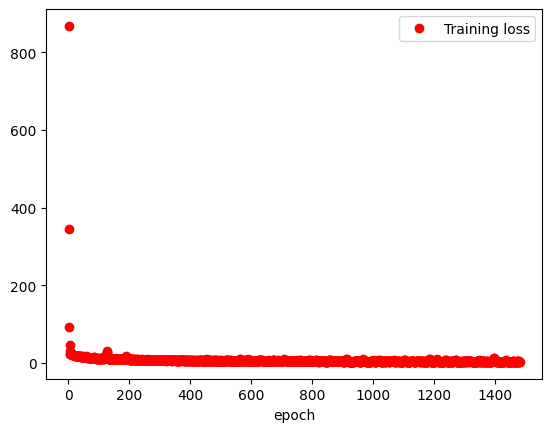

In [ ]:
# To plot training loss only
loss = model_history.history['loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


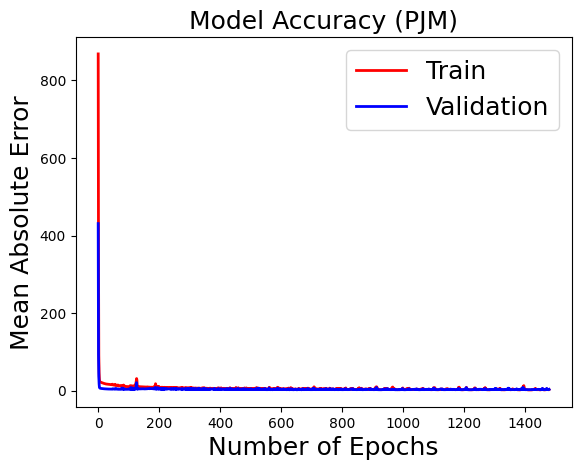

In [ ]:
# list all data in history
print(model_history.history.keys())
%matplotlib inline
# summarize history for accuracy
acc = model_history.history['mean_squared_error']
val_acc = model_history.history['val_mean_squared_error']
hfont = {'fontname':'Arial'}
plt.plot(acc, color='red',linewidth=2)
plt.plot(val_acc, color='blue',linewidth=2)
plt.title('Model Accuracy (NP)', fontsize=18, **hfont)
plt.ylabel('Mean Absolute Error', fontsize=18, **hfont)
plt.xlabel('Number of Epochs', fontsize=18, **hfont)
plt.legend(['Train', 'Validation'], loc='upper right', prop={"size":18})
plt.savefig('modelAccuracyPJM.pdf')
plt.show()

In [ ]:
y_pred = model.predict(X_test)   

23/23 [==============================] - 0s 3ms/step


In [ ]:
y_pred.shape

(727, 24)

In [ ]:
#inverse transform
#from sklearn import preprocessing
#y_pred = StandardScaler().inverse_transform(y_pred)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


#rMAE_test(y_test, y_pred):
 #   numerator = np.sum(np.abs(y_pred - y_test))
  #  denominator = np.sum(np.abs(np.mean(y_test) - y_test))
   # return numerator / denominator

rMAE= (np.sum(np.abs(y_pred - y_test)))/(np.sum(np.abs(np.mean(y_test) - y_test)))
#print("Test relative Mean absolute error (rMAE): {}".format(rMAE))


# Evaluating the model # Test error
# Measure MAE error
mae_test = metrics.mean_absolute_error(y_test, y_pred)
print("Test Mean absolute error (MAE): {}".format(mae_test))

# Measure MSE error  
#mse_test = metrics.mean_squared_error(y_test, y_pred)
#print("Test Mean Squared error (MSE): {}".format(mse_test))

# Measure MAPE error
mape_test = np.mean(np.abs((y_test - y_pred)/y_test))*100
#mape_test = metrics.mean_absolute_percentage_error(y_test, y_pred)
print("Test Mean percentage absolute error (MAPE in %): {}".format(mape_test))

# Measure sMAPE
sMAPE = 4.17/len(y_pred)*(np.sum(2 * np.abs(y_pred-y_test)/(np.abs(y_test) + np.abs(y_pred))))
#sMAPE = 1/len(y_test)*np.sum(2 * np.abs(y_pred-y_test)/(np.abs(y_test) + np.abs(y_pred)))
print("Test symmetric mean absolute percentage error (sMAPE in %): {}".format(sMAPE))


 #   def smape(A, F):
    #return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


# Measure RMSE error 
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Test Root mean squared error (RMSE): {}".format(rmse_test))

Test Mean absolute error (MAE): 1.9255009065171151
Test Mean percentage absolute error (MAPE in %): 6.122571858219226
Test symmetric mean absolute percentage error (sMAPE in %): 5.654508471700656
Test Root mean squared error (RMSE): 3.633747350372898


In [ ]:
# Regression score for training

r2_score_train = metrics.r2_score(y_test, y_pred)
print("R2 Score Train: {}".format(r2_score_train))

R2 Score Train: 0.8866359013560796


In [ ]:
y_pred.shape

(727, 24)

In [ ]:
y_test.shape

(727, 24)

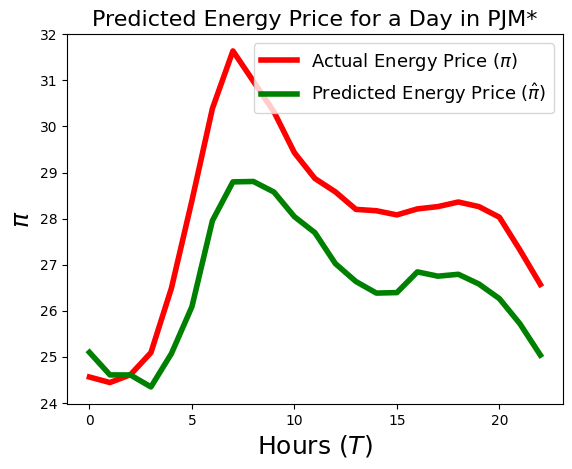

In [ ]:
test = y_test[100,1:]
#test =np.roll(test, -1) #rotate left
pred = y_pred[100,1:]
plt.plot(test, color='red',linewidth=4)
plt.plot(pred, color='green',linewidth=4)
plt.title('Predicted Energy Price for a Day in PJM*', fontsize=16, **hfont)
plt.ylabel('$\pi$', fontsize=18, **hfont)
plt.xlabel('Hours ($T$)', fontsize=18, **hfont)
plt.legend(['Actual Energy Price ($\pi$)', 'Predicted Energy Price ($\hat{\pi}$)'], loc='best', prop={"size":13})
plt.savefig('Prediction Curve for a day in PJM.pdf')

In [ ]:
y_test.shape

(727, 24)

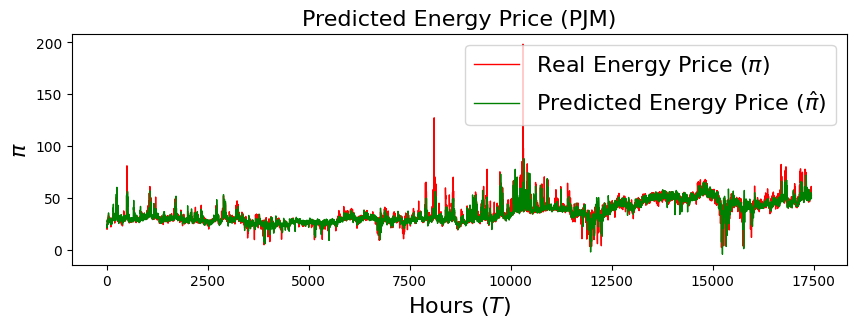

In [ ]:
y_test_reshape = y_test.reshape(-1)
y_pred_reshape = y_pred.reshape(-1)

plt.figure(figsize=(10,3))
plt.plot(y_test_reshape, color='red',linewidth=1)
plt.plot(y_pred_reshape, color='green',linewidth=1)
plt.title('Predicted Energy Price (PJM)', fontsize=16, **hfont)
plt.ylabel('$\pi$', fontsize=16, **hfont)
plt.xlabel('Hours ($T$)', fontsize=16, **hfont)
plt.legend(['Real Energy Price ($\pi$)', 'Predicted Energy Price ($\hat{\pi}$)'], loc='best', prop={"size":16})
plt.savefig('Prediction Curve PJM for T1.pdf')

In [ ]:
df1 = pd.DataFrame(y_pred)

df1.to_csv('pred_data_NP.csv')

In [ ]:
df2 = pd.DataFrame(y_test)

df2.to_csv('test_data.csv')

In [ ]:
end = timer()
print(timedelta(seconds=end-start))

0:05:21.307217


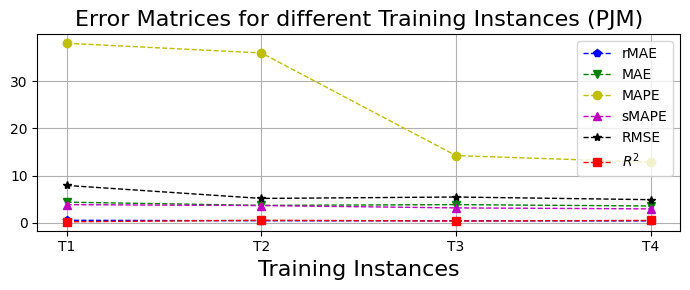

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
hfont = {'fontname':'Arial'}
#plt.plot(EpisodeIndex, color='red',linewidth=3)

rMAE  = [0.55, 0.45, 0.44, 0.42]
MAE  = [4.38, 3.70, 3.86, 3.57]
MAPE = [37.98, 35.93, 14.22, 12.85]
sMAPE = [3.86, 3.66, 3.17, 2.96]
RMSE = [7.92, 5.17, 5.47, 4.91]
R2 = [0.23, 0.56, 0.39, 0.52]



plt.plot(rMAE,'p--', color='blue', linewidth=1)
plt.plot(MAE,'v--', color='green',linewidth=1)
plt.plot(MAPE,'o--', color='y',linewidth=1)
plt.plot(sMAPE,'^--', color='m',linewidth=1)
plt.plot(RMSE,'*--', color='k',linewidth=1)
plt.plot(R2,'s--', color='r',linewidth=1)
#plt.ylim(ymin = -15500)
#plt.ylim(ymax = 1000)
#plt.plot(AvgEpisodeReward_lr_3,'-.', color='blue',linewidth=2)
plt.title('Error Matrices for different Training Instances (PJM)', fontsize=16, **hfont)
#plt.ylabel('Average Reward $(\mathrm{r})$', fontsize=16, **hfont)
x1 = [0,1,2,3]
squad = ['T1','T2','T3','T4']
plt.xticks(x1, squad)
#plt.xticks(squad, minor=False, rotation=45)


plt.xlabel('Training Instances', fontsize=16, **hfont)
plt.legend(['rMAE', 'MAE', 'MAPE', 'sMAPE', 'RMSE', '$R^2$' ], loc='upper right', prop={"size":10})
plt.grid()
plt.tight_layout()
plt.savefig('variablesPJM.pdf')
plt.show()
